In [ ]:
#system specs

!nvidia-smi

Sat Aug 22 23:25:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [ ]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install numpy==1.17
!pip install PyYAML==5.3.1
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 26kB/s 
     |████████████████████████████████| 6.6MB 39.5MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
     |████████████████████████████████| 20.4MB 158kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


     |████████████████████████████████| 276kB 4.5MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=436e306052c4e9e32024fdffab4d7193c9e9f168e4b8206fdb7874f168f65a1e
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-lbw5pwwa
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-lbw5pwwa
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266492 sha256=171a0700abe6d6e6ce120346ad42105fee1aa74e4b696896c0f568651956430e
  Stored in directory: /tmp/pip-ephem-wheel-cache-gbxcow1m/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing insta

In [ ]:
#get dataset
!gdown --id 1uWdQ2kn25RSQITtBHa9_zayplm27IXNC

Downloading...
From: https://drive.google.com/uc?id=1uWdQ2kn25RSQITtBHa9_zayplm27IXNC
To: /content/clothing.json
100% 199k/199k [00:00<00:00, 93.4MB/s]


 import all required libraries:

In [ ]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import argparse

import torch.distributed as dist
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter

import test  # import test.py to get mAP after each epoch
from models.yolo import Model
from utils import google_utils
from utils.datasets import *



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#each json line contains information for an object.
object = []
with open("object.json") as f:
    for line in f:
        object.append(json.loads(line))

In [ ]:
#data for picture 1
object[0]

In [ ]:
#display all
object_classes = []
for c in object:
  for a in c['annotation']:
    object_classes.extend(a['label'])
object_classes = list(set(object_classes))
object_classes

['Jackets',
 'Jeans',
 'Shirts',
 'Shoes',
 'Skirts',
 'Tops',
 'Trousers',
 'Tshirts',
 'sunglasses']

We have 9 different categories

In [ ]:
#divide data into training and testing
train_object, val_object = train_test_split(object, test_size=0.1)
len(train_clothing), len(val_clothing)

(453, 51)

In [ ]:
row = train_clothing[10]

obj = urllib.request.urlopen(row["content"])
obj = Image.open(obj)
obj = obj.convert('RGB')

obj.save("demo_image.jpeg", "JPEG")

In [ ]:
#acquire the bounding boxes
row
obj = cv2.cvtColor(cv2.imread(f'demo_image.jpeg'), cv2.COLOR_BGR2RGB)
obj.shape

{'annotation': [{'imageHeight': 312,
   'imageWidth': 145,
   'label': ['Tops'],
   'notes': '',
   'points': [{'x': 0.013793103448275862, 'y': 0.22756410256410256},
    {'x': 1, 'y': 0.7948717948717948}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/ec339ad6-6b73-406a-8971-f7ea35d47577___Data_s-top-203-red-srw-original-imaf2nfrxdzvhh3k.jpeg',
 'extras': None}

In [ ]:
for a in row['annotation']:
  for label in a['label']:

    w = a['imageWidth']
    h = a['imageHeight']

    points = a['points']
    p1, p2 = points

    x1, y1 = p1['x'] * w, p1['y'] * h
    x2, y2 = p2['x'] * w, p2['y'] * h

    cv2.rectangle(
      obj,
      (int(x1), int(y1)),
      (int(x2), int(y2)),
      color=(0, 255, 0),
      thickness=2
    )

    ((label_width, label_height), _) = cv2.getTextSize(
        label, 
        fontFace=cv2.FONT_HERSHEY_PLAIN,
        fontScale=1.75, 
        thickness=2
    )

    cv2.rectangle(
      obj,
      (int(x1), int(y1)),
      (int(x1 + label_width + label_width * 0.05), int(y1 + label_height + label_height * 0.25)),
      color=(0, 255, 0),
      thickness=cv2.FILLED
    )

    cv2.putText(
      obj,
      label,
      org=(int(x1), int(y1 + label_height + label_height * 0.25)), # bottom left
      fontFace=cv2.FONT_HERSHEY_PLAIN,
      fontScale=1.75,
      color=(255, 255, 255),
      thickness=2
    )

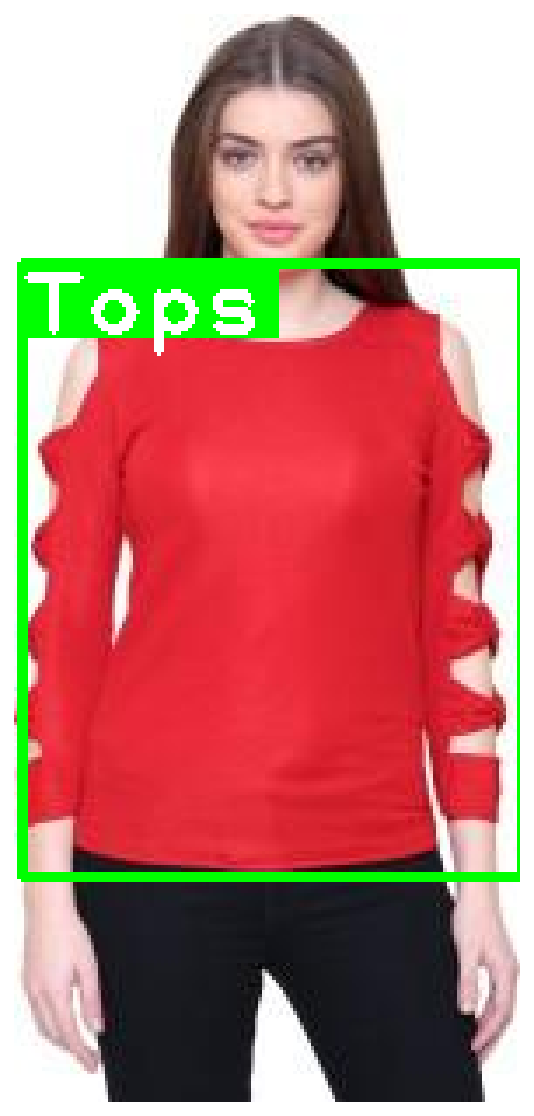

In [ ]:
plt.imshow(obj)
plt.axis('off');

In [ ]:
#convert dataset into yolo format since that is more meaningful and info

def create_dataset(object, categories, dataset_type):

  images_path = Path(f"clothing/images/{dataset_type}")
  images_path.mkdir(parents=True, exist_ok=True)

  labels_path = Path(f"clothing/labels/{dataset_type}")
  labels_path.mkdir(parents=True, exist_ok=True)

  for img_id, row in enumerate(tqdm(object)):

    image_name = f"{img_id}.jpeg"

    obj = urllib.request.urlopen(row["content"])
    obj = Image.open(obj)
    obj = obj.convert("RGB")

    obj.save(str(images_path / image_name), "JPEG")

    label_name = f"{img_id}.txt"

    with (labels_path / label_name).open(mode="w") as label_file:

      for a in row['annotation']:

        for label in a['label']:

          category_idx = categories.index(label)

          points = a['points']
          p1, p2 = points

          x1, y1 = p1['x'], p1['y']
          x2, y2 = p2['x'], p2['y']

          bbox_width = x2 - x1
          bbox_height = y2 - y1

          label_file.write(
            f"{category_idx} {x1 + bbox_width / 2} {y1 + bbox_height / 2} {bbox_width} {bbox_height}\n"
          )

In [ ]:
create_dataset(train_clothing, object_classes, 'train')
create_dataset(val_clothing, object_classes, 'val')

100%|██████████| 51/51 [00:09<00:00,  5.11it/s]


In [ ]:
!tree object -L 2

clothing
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories, 0 files


In [ ]:
!cat clothing/labels/train/0.txt

4 0.525462962962963 0.5432692307692308 0.9027777777777778 0.9006410256410257


In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git checkout ec72eea62bf5bb86b0272f2e65e413957533507f

Cloning into 'yolov5'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 2327 (delta 28), reused 35 (delta 14), pack-reused 2273
Receiving objects: 100% (2327/2327), 5.34 MiB | 12.60 MiB/s, done.
Resolving deltas: 100% (1525/1525), done.
/content/yolov5
Note: checking out 'ec72eea62bf5bb86b0272f2e65e413957533507f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at ec72eea Merge remote-tracking branch 'origin/master'


In [ ]:
!gdown --id 1ZycPS5Ft_0vlfgHnLsfvZPhcH6qOAqBO -O data/clothing.yaml
!gdown --id 1czESPsKbOWZF7_PkCcvRfTiUUJfpx12i -O models/yolov5x.yaml

Downloading...
From: https://drive.google.com/uc?id=1ZycPS5Ft_0vlfgHnLsfvZPhcH6qOAqBO
To: /content/yolov5/data/clothing.yaml
100% 172/172 [00:00<00:00, 260kB/s]
Downloading...
From: https://drive.google.com/uc?id=1czESPsKbOWZF7_PkCcvRfTiUUJfpx12i
To: /content/yolov5/models/yolov5x.yaml
100% 1.58k/1.58k [00:00<00:00, 1.40MB/s]


In [ ]:
!rm train.py

In [ ]:
%%writefile train.py

from utils.utils import *
prec = True
try:  
    from apex import amp
except:
    print(' https://github.com/NVIDIA/apex')
    prec = False  

dir_wei = 'weights' + os.sep  # weights dir
os.makedirs(dir_wei, exist_ok=True)
last = dir_wei + 'last.pt'
best = dir_wei + 'best.pt'
final_res = 'results.txt'


Para = {'lr0': 0.01,  'momentum': 0.937,  'weight_decay': 5e-4, 'giou': 0.05,'cls': 0.58,'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'anchor_t': 4.0,'fl_gamma': 0.0,
       'hsv_h': 0.014, 'hsv_s': 0.68,'hsv_v': 0.36, 'degrees': 0.0,'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
print(Para)

f = glob.glob('Para*.txt')
if f:
    print('Using %s' % f[0])
    for File, L in zip(Para.keys(), np.loadtxt(f[0])):
        Para[ File] = L

if Para['fl_gamma']:
    print('Using FocalLoss(gamma=%g)' % Para['fl_gamma'])





Writing train.py


In [ ]:
def train(Para):
    epochs = opt.epochs  # 300
    batch_size = opt.batch_size  # 64
    weights = opt.weights  # initial training weights

    # Configure
    init_seeds(1)
    with open(opt.data) as f:
        data_dict = yaml.load(f, Loader=yaml.FullLoader)  # model dict
    train_path = data_dict['train']
    test_path = data_dict['val']
    nc = 1 if opt.single_cls else int(data_dict['nc'])  # number of classes

    # Remove previous results
    for f in glob.glob('*_batch*.jpg') + glob.glob(final_res):
        os.remove(f)

    # Create model
    model = Model(opt.cfg).to(device)
    assert model.md['nc'] == nc, '%s nc=%g classes but %s nc=%g classes' % (opt.data, nc, opt.cfg, model.md['nc'])

    # Image sizes
    gs = int(max(model.stride))  # grid size (max stride)
    imgsz, imgsz_test = [check_img_size(x, gs) for x in opt.img_size]  # verify imgsz are gs-multiples

    # Optimizer
    nbs = 64  # nominal batch size
    accumulate = max(round(nbs / batch_size), 1)  # accumulate loss before optimizing
    Para['weight_decay'] *= batch_size * accumulate / nbs  # scale weight_decay
    pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
    for  File, v in model.named_parameters():
        if v.requires_grad:
            if '.bias' in k:
                pg2.append(v)  # biases
            elif '.weight' in k and '.bn' not in k:
                pg1.append(v)  # apply weight decay
            else:
                pg0.append(v)  # all else

    optimizer = optim.Adam(pg0, lr=Para['lr0']) if opt.adam else \
        optim.SGD(pg0, lr=Para['lr0'], momentum=Para['momentum'], nesterov=True)
    optimizer.add_param_group({'params': pg1, 'weight_decay': Para['weight_decay']})  # add pg1 with weight_decay
    optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
    print('Optimizer groups: %g .bias, %g conv.weight, %g other' % (len(pg2), len(pg1), len(pg0)))
    del pg0, pg1, pg2

    # Load Model
    google_utils.attempt_download(weights)
    start_epoch, best_fitness = 0, 0.0
    if weights.endswith('.pt'):  # pytorch format
        ckpt = torch.load(weights, map_location=device)  # load checkpoint

        # load optimizer
        if ckpt['optimizer'] is not None:
            optimizer.load_state_dict(ckpt['optimizer'])
            best_fitness = ckpt['best_fitness']

        # load results
        if ckpt.get('training_results') is not None:
            with open(final_res, 'w') as file:
                file.write(ckpt['training_results'])  # write results.txt

        start_epoch = ckpt['epoch'] + 1
        del ckpt

    # Mixed precision training https://github.com/NVIDIA/apex
    if prec:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # Scheduler https://arxiv.org/pdf/1812.01187.pdf
    lf = lambda x: (((1 + math.cos(x * math.pi / epochs)) / 2) ** 1.0) * 0.9 + 0.1  # cosine
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    scheduler.last_epoch = start_epoch - 1  # do not move
    # https://discuss.pytorch.org/t/a-problem-occured-when-resuming-an-optimizer/28822
    # plot_lr_scheduler(optimizer, scheduler, epochs)

    # Initialize distributed training
    if device.type != 'cpu' and torch.cuda.device_count() > 1 and torch.distributed.is_available():
        dist.init_process_group(backend='nccl',  # distributed backend
                                init_method='tcp://127.0.0.1:9999',  # init method
                                world_size=1,  # number of nodes
                                rank=0)  # node rank
        model = torch.nn.parallel.DistributedDataParallel(model)
        # pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html

    # Dataset
    dataset = LoadImagesAndLabels(train_path, imgsz, batch_size,
                                  augment=True,
                                  Para=Para,  # augmentation hyperparameters
                                  rect=opt.rect,  # rectangular training
                                  cache_images=opt.cache_images,
                                  single_cls=opt.single_cls)
    mlc = np.concatenate(dataset.labels, 0)[:, 0].max()  # max label class
    assert mlc < nc, 'Label class %g exceeds nc=%g in %s. Correct your labels or your model.' % (mlc, nc, opt.cfg)

    # Dataloader
    batch_size = min(batch_size, len(dataset))
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             num_workers=nw,
                                             shuffle=not opt.rect,  # Shuffle=True unless rectangular training is used
                                             pin_memory=True,
                                             collate_fn=dataset.collate_fn)

    # Testloader
    testloader = torch.utils.data.DataLoader(LoadImagesAndLabels(test_path, imgsz_test, batch_size,
                                                                 Para=Para,
                                                                 rect=True,
                                                                 cache_images=opt.cache_images,
                                                                 single_cls=opt.single_cls),
                                             batch_size=batch_size,
                                             num_workers=nw,
                                             pin_memory=True,
                                             collate_fn=dataset.collate_fn)

    # Model parameters
    Para['cls'] *= nc / 80.  # scale coco-tuned Para['cls'] to current dataset
    model.nc = nc  # attach number of classes to model
    model.Para = Para  # attach hyperparameters to model
    model.gr = 1.0  # giou loss ratio (obj_loss = 1.0 or giou)
    model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device)  # attach class weights
    model.names = data_dict['names']

    # Class frequency
    labels = np.concatenate(dataset.labels, 0)
    c = torch.tensor(labels[:, 0])  # classes
    # cf = torch.bincount(c.long(), minlength=nc) + 1.
    # model._initialize_biases(cf.to(device))
    if summ_write:
        plot_labels(labels)
        summ_write.add_histogram('classes', c, 0)

    # Check anchors
    if not opt.noautoanchor:
        check_anchors(dataset, model=model, thr=Para['anchor_t'], imgsz=imgsz)

    # Exponential moving average
    ema = torch_utils.ModelEMA(model)

    # Start training
    t0 = time.time()
    nb = len(dataloader)  # number of batches
    n_burn = max(3 * nb, 1e3)  # burn-in iterations, max(3 epochs, 1k iterations)
    maps = np.zeros(nc)  # mAP per class
    results = (0, 0, 0, 0, 0, 0, 0)  # 'P', 'R', 'mAP', 'F1', 'val GIoU', 'val Objectness', 'val Classification'
    print('Image sizes %g train, %g test' % (imgsz, imgsz_test))
    print('Using %g dataloader workers' % nw)
    print('Starting training for %g epochs...' % epochs)
    # torch.autograd.set_detect_anomaly(True)
    for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
        model.train()

        # Update image weights (optional)
        if dataset.image_weights:
            w = model.class_weights.cpu().numpy() * (1 - maps) ** 2  # class weights
            image_weights = labels_to_image_weights(dataset.labels, nc=nc, class_weights=w)
            dataset.indices = random.choices(range(dataset.n), weights=image_weights, k=dataset.n)  # rand weighted idx

        mloss = torch.zeros(4, device=device)  # mean losses
        print(('\n' + '%10s' * 8) % ('Epoch', 'gpu_mem', 'GIoU', 'obj', 'cls', 'total', 'targets', 'img_size'))
        pbar = tqdm(enumerate(dataloader), total=nb)  # progress bar
        for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device).float() / 255.0  # uint8 to float32, 0 - 255 to 0.0 - 1.0

            # Burn-in
            if ni <= n_burn:
                xi = [0, n_burn]  # x interp
                # model.gr = np.interp(ni, xi, [0.0, 1.0])  # giou loss ratio (obj_loss = 1.0 or giou)
                accumulate = max(1, np.interp(ni, xi, [1, nbs / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [0.1 if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [0.9, Para['momentum']])

            # Multi-scale
            if opt.multi_scale:
                sz = random.randrange(imgsz * 0.5, imgsz * 1.5 + gs) // gs * gs  # size
                sf = sz / max(imgs.shape[2:])  # scale factor
                if sf != 1:
                    ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to gs-multiple)
                    imgs = F.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

            # Forward
            pred = model(imgs)

            # Loss
            loss, loss_items = compute_loss(pred, targets.to(device), model)
            if not torch.isfinite(loss):
                print('WARNING: non-finite loss, ending training ', loss_items)
                return results

            # Backward
            if prec:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            # Optimize
            if ni % accumulate == 0:
                optimizer.step()
                optimizer.zero_grad()
                ema.update(model)

            # Print
            mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
            mem = '%.3gG' % (torch.cuda.memory_cached() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
            s = ('%10s' * 2 + '%10.4g' * 6) % (
                '%g/%g' % (epoch, epochs - 1), mem, *mloss, targets.shape[0], imgs.shape[-1])
            pbar.set_description(s)

            # Plot
            if ni < 3:
                f = 'train_batch%g.jpg' % i  # filename
                res = plot_images(images=imgs, targets=targets, paths=paths, fname=f)
                if summ_write:
                    summ_write.add_image(f, res, dataformats='HWC', global_step=epoch)
                    # summ_write.add_graph(model, imgs)  # add model to tensorboard

            # end batch ------------------------------------------------------------------------------------------------

        # Scheduler
        scheduler.step()

        # mAP
        ema.update_attr(model)
        final_epoch = epoch + 1 == epochs
        if not opt.notest or final_epoch:  # Calculate mAP
            results, maps, times = test.test(opt.data,
                                             batch_size=batch_size,
                                             imgsz=imgsz_test,
                                             save_json=final_epoch and opt.data.endswith(os.sep + 'coco.yaml'),
                                             model=ema.ema,
                                             single_cls=opt.single_cls,
                                             dataloader=testloader)

        # Write
        with open(final_res, 'a') as f:
            f.write(s + '%10.4g' * 7 % results + '\n')  # P, R, mAP, F1, test_losses=(GIoU, obj, cls)
        if len(opt.name) and opt.bucket:
            os.system('gsutil cp results.txt gs://%s/results/results%s.txt' % (opt.bucket, opt.name))

        # Tensorboard
        if summ_write:
            tags = ['train/giou_loss', 'train/obj_loss', 'train/cls_loss',
                    'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/F1',
                    'val/giou_loss', 'val/obj_loss', 'val/cls_loss']
            for x, tag in zip(list(mloss[:-1]) + list(results), tags):
                summ_write.add_scalar(tag, x, epoch)

        # Update best mAP
        fi = fitness(np.array(results).reshape(1, -1))  # fitness_i = weighted combination of [P, R, mAP, F1]
        if fi > best_fitness:
            best_fitness = fi

        # Save model
        save = (not opt.nosave) or (final_epoch and not opt.evolve)
        if save:
            with open(final_res, 'r') as f:  # create checkpoint
                ckpt = {'epoch': epoch,
                        'best_fitness': best_fitness,
                        'training_results': f.read(),
                        'model': ema.ema.module if hasattr(model, 'module') else ema.ema,
                        'optimizer': None if final_epoch else optimizer.state_dict()}

            # Save last, best and delete
            torch.save(ckpt, last)
            if (best_fitness == fi) and not final_epoch:
                torch.save(ckpt, best)
            del ckpt

        # end epoch ----------------------------------------------------------------------------------------------------
    # end training

    n = opt.name
    if len(n):
        n = '_' + n if not n.isnumeric() else n
        fresults, flast, fbest = 'results%s.txt' % n, dir_wei + 'last%s.pt' % n, dir_wei + 'best%s.pt' % n
        for f1, f2 in zip([dir_wei + 'last.pt', dir_wei + 'best.pt', 'results.txt'], [flast, fbest, fresults]):
            if os.path.exists(f1):
                os.rename(f1, f2)  # rename
                ispt = f2.endswith('.pt')  # is *.pt
                strip_optimizer(f2) if ispt else None  # strip optimizer
                os.system('gsutil cp %s gs://%s/weights' % (f2, opt.bucket)) if opt.bucket and ispt else None  # upload

    if not opt.evolve:
        plot_results()  # save as results.png
    print('%g epochs completed in %.3f hours.\n' % (epoch - start_epoch + 1, (time.time() - t0) / 3600))
    dist.destroy_process_group() if device.type != 'cpu' and torch.cuda.device_count() > 1 else None
    torch.cuda.empty_cache()
    return results


In [ ]:
if __name__ == '__main__':
    check_git_status()
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=300)
    parser.add_argument('--batch-size', type=int, default=16)
    parser.add_argument('--cfg', type=str, default='models/yolov5s.yaml', help='*.cfg path')
    parser.add_argument('--data', type=str, default='data/coco128.yaml', help='*.data path')
    parser.add_argument('--img-size', nargs='+', type=int, default=[640, 640], help='train,test sizes')
    parser.add_argument('--rect', action='store_true', help='rectangular training')
    parser.add_argument('--resume', action='store_true', help='resume training from last.pt')
    parser.add_argument('--nosave', action='store_true', help='only save final checkpoint')
    parser.add_argument('--notest', action='store_true', help='only test final epoch')
    parser.add_argument('--noautoanchor', action='store_true', help='disable autoanchor check')
    parser.add_argument('--evolve', action='store_true', help='evolve hyperparameters')
    parser.add_argument('--bucket', type=str, default='', help='gsutil bucket')
    parser.add_argument('--cache-images', action='store_true', help='cache images for faster training')
    parser.add_argument('--weights', type=str, default='', help='initial weights path')
    parser.add_argument('--name', default='', help='renames results.txt to results_name.txt if supplied')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--adam', action='store_true', help='use adam optimizer')
    parser.add_argument('--multi-scale', action='store_true', help='vary img-size +/- 50%')
    parser.add_argument('--single-cls', action='store_true', help='train as single-class dataset')
    opt = parser.parse_args()
    opt.weights = last if opt.resume else opt.weights
    opt.cfg = check_file(opt.cfg)  
    opt.data = check_file(opt.data)  
    print(opt)
    opt.img_size.extend([opt.img_size[-1]] * (2 - len(opt.img_size)))  # extend to 2 sizes (train, test)
    device = torch_utils.select_device(opt.device, apex=prec, batch_size=opt.batch_size)
    if device.type == 'cpu':
        prec = False

    # Train
    if not opt.evolve:
        summ_write = SummaryWriter(comment=opt.name)
        print(' view http://localhost:6006/')
        train(Para)

 
    else:
        summ_write = None
        opt.notest, opt.nosave = True, True  # only test/save final epoch
        if opt.bucket:
            os.system('gsutil cp gs://%s/evolve.txt .' % opt.bucket)  # download evolve.txt if exists

        for _ in range(10):  # generations to evolve
            if os.path.exists('evolve.txt'):  # if evolve.txt exists: select best hyps and mutate
                # Select parent(s)
                parent = 'single'  # parent selection method: 'single' or 'weighted'
                x = np.loadtxt('evolve.txt', ndmin=2)
                n = min(5, len(x))  
                x = x[np.argsort(-fitness(x))][:n]  
                w = fitness(x) - fitness(x).min() 
                if parent == 'single' or len(x) == 1:
                    # x = x[random.randint(0, n - 1)]  # random selection
                    x = x[random.choices(range(n), weights=w)[0]]  
                elif parent == 'weighted':
                    x = (x * w.reshape(n, 1)).sum(0) / w.sum()  

                # Mutate
                mp, s = 0.9, 0.2  
                npr = np.random
                npr.seed(int(time.time()))
                arr = np.array([1, 1, 1, 1, 1, 1, 1, 0, .1, 1, 0, 1, 1, 1, 1, 1, 1, 1])  
                leg = len(arr)
                val = np.ones(leg)
                while all(val == 1):  
                    val = (arr * (npr.random(ng) < mp) * npr.randn(ng) * npr.random() * s + 1).clip(0.3, 3.0)
                for i, k in enumerate(Para.keys()):  # plt.hist(v.ravel(), 300)
                    Para[k] = x[i + 7] * val[i]  

            # Clip to limits
            keys = ['lr0', 'iou_t', 'momentum', 'weight_decay', 'hsv_s', 'hsv_v', 'translate', 'scale', 'fl_gamma']
            limits = [(1e-5, 1e-2), (0.00, 0.70), (0.60, 0.98), (0, 0.001), (0, .9), (0, .9), (0, .9), (0, .9), (0, 3)]
            for  File, L in zip(keys, limits):
                Para[k] = np.clip(Para[k], val[0], val[1])

            # Train mutation
            results = train(Para.copy())

            # Write mutation results
            print_mutation(Para, results, opt.bucket)

            # Plot results
            # plot_evolution_results(Para)

In [ ]:
#training

!python train.py --obj 640 --batch 4 --epochs 10 \
  --data ./data/clothing.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt \
  --name yolov5x_clothing --cache

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Namespace(adam=False, batch_size=4, bucket='', cache_images=True, cfg='./models/yolov5x.yaml', data='./data/clothing.yaml', device='', epochs=10, evolve=False, img_size=[640], multi_scale=False, name='yolov5x_clothing', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='yolov5x.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-08-22 23:30:24.579080: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Start Tensorboard with "tensorboard --logdir=runs", view at http://local

The training took around 0.267 hours on Tesla P100. The best model checkpoint is saved to `weights/best_yolov5x_clothing.pt`.